gev = genextreme(-0.10161380555209218, 
                 0.10243008255436033, 
                 0.06567245306678968)

data = gev.rvs(size=100000)
mu, std = norm.fit(data)
print(mu, std, np.max(data), (np.max(data)-mu)/2.5)

In [1]:
import os
import json
import time
import pickle
import matplotlib
import numpy as np
import networkx as nx
import matplotlib.pyplot as plt
from estimators import GaussEstimator, GEVEstimator
from scipy.stats import norm, multivariate_normal, genextreme

#### Leak rate convergence

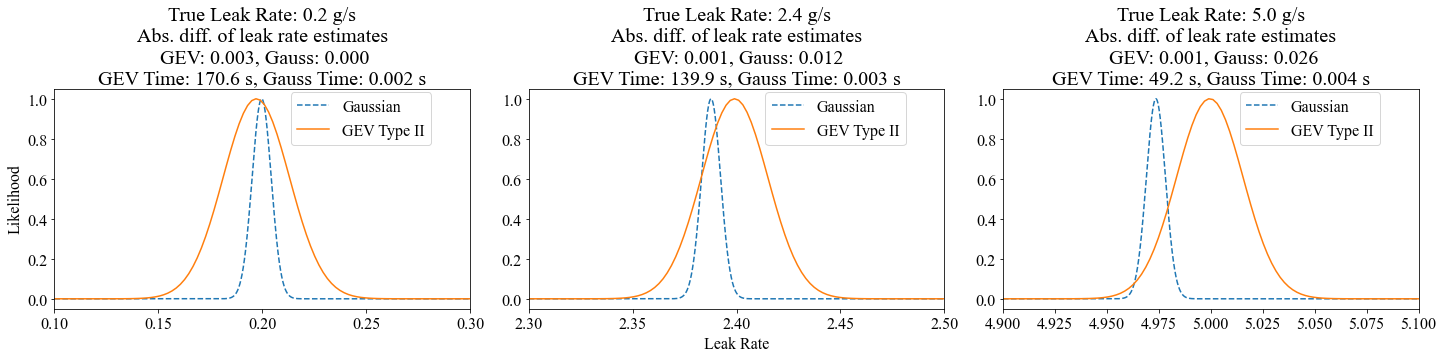

In [9]:
font = {'family' : 'Times New Roman',
        'weight' : 'normal',
        'size'   : 16}
matplotlib.rc('font', **font)

y = np.linspace(-1, 1, 10)
x = np.ones_like(y)
z = np.ones_like(x)

rows = 0
cols = 0
fig, axs = plt.subplots(1, 3, figsize=(20, 5))

for rate in [0.2, 2.4, 5.0]:
    model_gev = GEVEstimator(rate)
    model_gau = GaussEstimator(rate)
    M = model_gau.dispersion(x, y, z)*rate

    start_gau = time.time()
    mu, sigma = model_gau.leak_rate(M, x, y, z, True)
    end_gau = time.time()
    
    start_gev = time.time()
    x_range, gev_y = model_gev.leak_rate(M, x, y, z, False, (rate-0.1, rate+0.1))
    end_gev = time.time()
        
    gev_y = 1.0*(gev_y - np.min(gev_y))/np.ptp(gev_y)

    x_range_gau = np.linspace(rate-0.1, rate+0.1, 10000)
    gau_y = norm.pdf(x_range_gau, mu, sigma)
    gau_y = 1.0*(gau_y - np.min(gau_y))/np.ptp(gau_y)

    axs[rows].plot(x_range_gau, gau_y, linestyle='dashed', label='Gaussian')
    axs[rows].plot(x_range, gev_y, linestyle='solid', label='GEV Type II')
    axs[rows].set_xlim(x_range.min(), x_range.max())
    axs[rows].set_title("True Leak Rate: {} g/s\nAbs. diff. of leak rate estimates\n GEV: {:.3f}, Gauss: {:.3f}\n GEV Time: {:.1f} s, Gauss Time: {:.3f} s ".format(
        rate, rate-x_range[np.argmax(gev_y)], rate-mu, end_gev-start_gev, end_gau-start_gau), size=20)
    rows += 1

fig.tight_layout()
fig.add_subplot(111, frame_on=False)
plt.tick_params(labelcolor="none", bottom=False, left=False)
plt.xlabel("Leak Rate")
plt.ylabel("Likelihood")
axs[0].legend(bbox_to_anchor=(0.55, 1.02), loc='upper left')
axs[1].legend(bbox_to_anchor=(0.55, 1.02), loc='upper left')
axs[2].legend(bbox_to_anchor=(0.55, 1.02), loc='upper left')
plt.savefig("GEVvsGauss.png", dpi=500)

#### Example graph sol paths

In [7]:
with open('./benchmark_gcb_iter-0_16.json', "r") as read_file:
    data = json.load(read_file)
    
map_ = list(data['iter_path'].keys())[0]
iter_path = data['iter_path'][map_]
arp_gcb_path = data['arp_gcb_path'][map_]
tsp_gcb_path = data['tsp_gcb_path'][map_]
iter_mse = data['iter_mse'][map_]
arp_gcb_mse = data['arp_gcb_mse'][map_]
tsp_gcb_mse = data['tsp_gcb_mse'][map_]

with open('../data/{}.pkl'.format(map_), 'rb') as file:
    data_dict = pickle.load(file)
G = data_dict['graph']
locs = data_dict['locs']
well_locs = data_dict['wells']

findfont: Font family ['Times New Roman'] not found. Falling back to DejaVu Sans.
findfont: Font family ['Times New Roman'] not found. Falling back to DejaVu Sans.


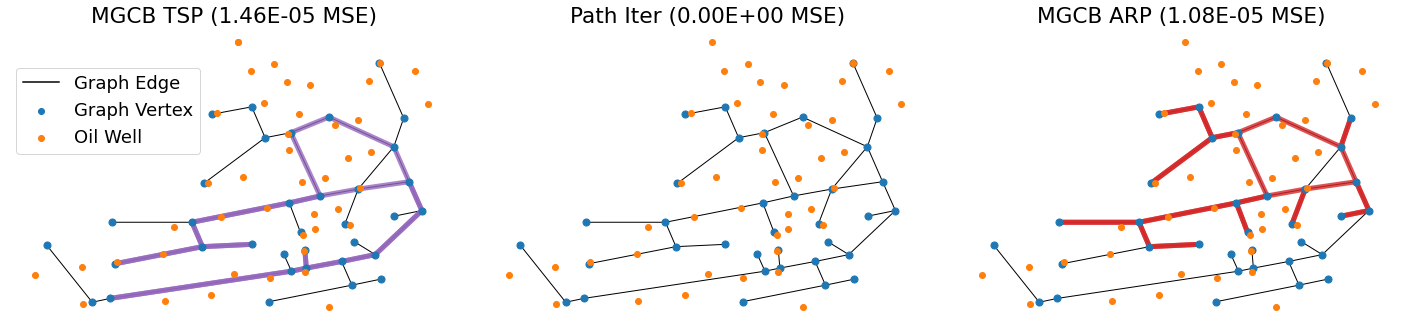

In [8]:
font = {'family' : 'Times New Roman',
        'weight' : 'normal',
        'size'   : 18}
matplotlib.rc('font', **font)

fig, axs = plt.subplots(1, 3, figsize=(20, 5))

nx.draw(G, pos=locs, node_size=50, ax=axs[0])
axs[0].scatter(well_locs[:, 0], well_locs[:, 1], c='C1', zorder=2)
path = [tuple(e) for e in tsp_gcb_path]
nx.draw_networkx_edges(G, 
                       pos=locs, 
                       edgelist=path, 
                       edge_color='C4', 
                       width=5,
                       alpha=0.8,
                       ax=axs[0])
axs[0].set_title('MGCB TSP ({:.2E} MSE)'.format(tsp_gcb_mse))

nx.draw(G, pos=locs, node_size=50, ax=axs[1])
axs[1].scatter(well_locs[:, 0], well_locs[:, 1], c='C1', zorder=2, label='Oil Well')
path = [tuple(e) for e in iter_path]
nx.draw_networkx_edges(G, 
                       pos=locs, 
                       edgelist=path, 
                       edge_color='C2', 
                       width=5,
                       alpha=0.8,
                       ax=axs[1])
axs[1].set_title('Path Iter ({:.2E} MSE)'.format(iter_mse))

nx.draw(G, pos=locs, node_size=50, ax=axs[2])
axs[2].scatter(well_locs[:, 0], well_locs[:, 1], c='C1', zorder=2, label='Oil Well')
path = [tuple(e) for e in arp_gcb_path]
nx.draw_networkx_edges(G, 
                       pos=locs, 
                       edgelist=path, 
                       edge_color='C3', 
                       width=5,
                       alpha=0.8,
                       ax=axs[2])
axs[2].set_title('MGCB ARP ({:.2E} MSE)'.format(arp_gcb_mse))

fig.tight_layout()

axs[0].plot(locs[0][0], locs[0][1], c='k', zorder=0, label='Graph Edge')
axs[0].scatter(locs[0][0], locs[0][1], c='C0', zorder=0, label='Graph Vertex')
axs[0].scatter(well_locs[0, 0], well_locs[0, 1], c='C1', zorder=2, label='Oil Well')
axs[0].legend(bbox_to_anchor=(0, 0.9), loc='upper left')

#plt.savefig('map.pdf', dpi=500, bbox_inches='tight')
extent = axs[0].get_window_extent().transformed(fig.dpi_scale_trans.inverted())
fig.savefig('map_mgcb_tsp.png', dpi=500, bbox_inches=extent)

extent = axs[1].get_window_extent().transformed(fig.dpi_scale_trans.inverted())
fig.savefig('map_piter.png', dpi=500, bbox_inches=extent)

extent = axs[2].get_window_extent().transformed(fig.dpi_scale_trans.inverted())
fig.savefig('map_mgcb_arp.png', dpi=500, bbox_inches=extent)

#### Leak rate convergence

In [ ]:
model = GaussEstimator()

y = np.linspace(-1, 1, 10)
x = np.ones_like(y)
z = np.ones_like(x)  

for s in [0.2, 0.8, 1.4, 2.4, 3.0, 5.0]:
    start_gev = time.time()
    eer_gev = model_gev(x*s, y, z)
    end_gev = time.time()
    
    start_gau = time.time()
    eer_gau = model_gau(x*s, y, z)
    end_gau = time.time()
    
    print("{} & {:.4E} & {:.4E} & {:.5f} & {:.5f} \\".format(s, eer_gev, eer_gau, end_gev-start_gev, end_gau-start_gau))

#### GCB benchmark

In [13]:
folder = '../sols/beta2'
files = []
for f in os.listdir(folder):
    if os.path.isfile(os.path.join(folder, f)) and 'json' in f:
        files.append(os.path.join(folder, f))
files.sort()
#print('\n'.join(map(str, files)))

iter_eer = []
arp_gcb_eer = []
varp_gcb_eer = []
tsp_gcb_eer = []
vtsp_gcb_eer = []

iter_mse = []
arp_gcb_mse = []
varp_gcb_mse = []
tsp_gcb_mse = []
vtsp_gcb_mse = []

iter_time = []
arp_gcb_time = []
varp_gcb_time = []
tsp_gcb_time = []
vtsp_gcb_time = []

iter_path = []
arp_gcb_path = []
varp_gcb_path = []
tsp_gcb_path = []
vtsp_gcb_path = []

nodes = []
edges = []
maps = []

leak_rates = []

for f in files:
    with open(f, "r") as read_file:
        data = json.load(read_file)

    iter_eer.extend(list(data['iter_eer'].values()))
    arp_gcb_eer.extend(list(data['arp_gcb_eer'].values()))
    varp_gcb_eer.extend(list(data['varp_gcb_eer'].values()))
    tsp_gcb_eer.extend(list(data['tsp_gcb_eer'].values()))
    vtsp_gcb_eer.extend(list(data['vtsp_gcb_eer'].values()))

    iter_mse.extend(list(data['iter_mse'].values()))
    arp_gcb_mse.extend(list(data['arp_gcb_mse'].values()))
    varp_gcb_mse.extend(list(data['varp_gcb_mse'].values()))
    tsp_gcb_mse.extend(list(data['tsp_gcb_mse'].values()))
    vtsp_gcb_mse.extend(list(data['vtsp_gcb_mse'].values()))
        
    iter_time.extend(list(data['iter_time'].values()))
    arp_gcb_time.extend(list(data['arp_gcb_time'].values()))
    varp_gcb_time.extend(list(data['varp_gcb_time'].values()))
    tsp_gcb_time.extend(list(data['tsp_gcb_time'].values()))
    vtsp_gcb_time.extend(list(data['vtsp_gcb_time'].values()))
    
    iter_path.extend(list(data['iter_path'].values()))
    arp_gcb_path.extend(list(data['arp_gcb_path'].values()))
    varp_gcb_path.extend(list(data['varp_gcb_path'].values()))
    tsp_gcb_path.extend(list(data['tsp_gcb_path'].values()))
    vtsp_gcb_path.extend(list(data['vtsp_gcb_path'].values()))
    
    for map_ in list(data['iter_path'].keys()):
        with open('../data/{}.pkl'.format(map_), 'rb') as file:
            data_dict = pickle.load(file)
        G = data_dict['graph']
        nodes.append(len(G.nodes()))
        edges.append(len(G.edges()))
        maps.append(map_)
        #connectivity.append(nx.average_node_connectivity(G))
stats = np.stack([nodes, edges, iter_mse, tsp_gcb_mse, arp_gcb_mse, iter_eer, tsp_gcb_eer, arp_gcb_eer, iter_time, tsp_gcb_time, arp_gcb_time])
np.savetxt('stats.csv', stats.T, delimiter=',')
#print(', '.join(map(str, data.keys())))
np.savetxt('maps.csv', maps, delimiter=',', fmt='%s')

print(f'Path Iter & {np.mean(iter_mse):.4E} & {np.std(iter_mse):.4E} & {np.mean(iter_time):.2f} & {np.std(iter_time):.2f} \\\\')
print(f'GCB TSP & {np.mean(vtsp_gcb_mse):.4E} & {np.std(vtsp_gcb_mse):.4E} & {np.mean(vtsp_gcb_time):.2f} & {np.std(vtsp_gcb_time):.2f} \\\\')
print(f'GCB ARP & {np.mean(varp_gcb_mse):.4E} & {np.std(varp_gcb_mse):.4E} & {np.mean(varp_gcb_time):.2f} & {np.std(varp_gcb_time):.2f} \\\\')
print(f'MGCB TSP & {np.mean(tsp_gcb_mse):.4E} & {np.std(tsp_gcb_mse):.4E} & {np.mean(tsp_gcb_time):.2f} & {np.std(tsp_gcb_time):.2f} \\\\')
print(f'MGCB ARP & {np.mean(arp_gcb_mse):.4E} & {np.std(arp_gcb_mse):.4E} & {np.mean(arp_gcb_time):.2f} & {np.std(arp_gcb_time):.2f} \\\\')

Path Iter & 1.6132E-01 & 1.2989E+00 & 1203.81 & 4.18 \\
GCB TSP & 7.5711E-05 & 2.7331E-04 & 1209.58 & 22.64 \\
GCB ARP & 2.5680E-05 & 1.3238E-04 & 1211.50 & 17.45 \\
MGCB TSP & 2.0583E-04 & 1.4948E-03 & 129.41 & 305.48 \\
MGCB ARP & 2.5680E-05 & 1.3238E-04 & 450.02 & 512.24 \\


#### Oil well stats

In [4]:
map_folder = "../data/"
maps = []
for f in os.listdir(map_folder):
    if os.path.isfile(os.path.join(map_folder, f)):
        maps.append(os.path.join(map_folder, f))
maps.sort()

num_wells = []
num_nodes = []
num_edges = []
avg_node_connectivity = []
for map_ in maps:
    with open(map_, 'rb') as file:
        data_dict = pickle.load(file)
        
    G = data_dict['graph']
    num_nodes.append(len(G.nodes()))
    num_edges.append(len(G.edges()))
    num_wells.append(len(data_dict['wells']))
    avg_node_connectivity.append(nx.average_node_connectivity(G))

In [5]:
print("{} & {} & {:.2f}".format(np.max(num_wells), np.min(num_wells), np.mean(num_wells)))
print("{} & {} & {:.2f}".format(np.max(num_nodes), np.min(num_nodes), np.mean(num_nodes)))
print("{} & {} & {:.2f}".format(np.max(num_edges), np.min(num_edges), np.mean(num_edges)))
print("{:.2f} & {:.2f} & {:.2f}".format(np.max(avg_node_connectivity), np.min(avg_node_connectivity), np.mean(avg_node_connectivity)))

145 & 11 & 35.50
420 & 15 & 77.64
484 & 16 & 82.47
1.10 & 1.00 & 1.04
